# Image Processing CookBook
## Chapter 10
### Author - Sandipan Dey

### Bangla MNIST Dataset (Numta)

In [2]:
# download the numta dataset from here: https://www.kaggle.com/BengaliAI/numta/version/4
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pylab as plt
from skimage.transform import resize
#from skimage.filters import threshold_otsu

df = pd.read_csv('images/Numta/training-a.csv')
print(df.shape)
df.head()

(19702, 7)


,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [ ]:
n = 28
df = pd.read_csv('../training-e.csv')

X_train = np.zeros((df.shape[0], n*n))

for i in range(df.shape[0]): 
    img = rgb2gray(imread('../training-e/' + df.iloc[i]['filename'])) 
    if i % 1000 == 0: print(i) 
    #img = resize(img, (n,n))
    # img = 1 - img
    X_train[i,:] = np.array([np.ravel(img)])

In [ ]:
from glob import glob

n = 28
test_images = glob('../testing-e/*.png')
print(len(test_images))

X_test = np.zeros((len(test_images), n*n))

for i in range(len(test_images)): 
    img = rgb2gray(imread(test_images[i])) 
    #if i % 1000 == 0: print(i) 
    img = resize(img, (n,n))
    # img = 1 - img
    X_test[i,:] = np.array([np.ravel(img)])

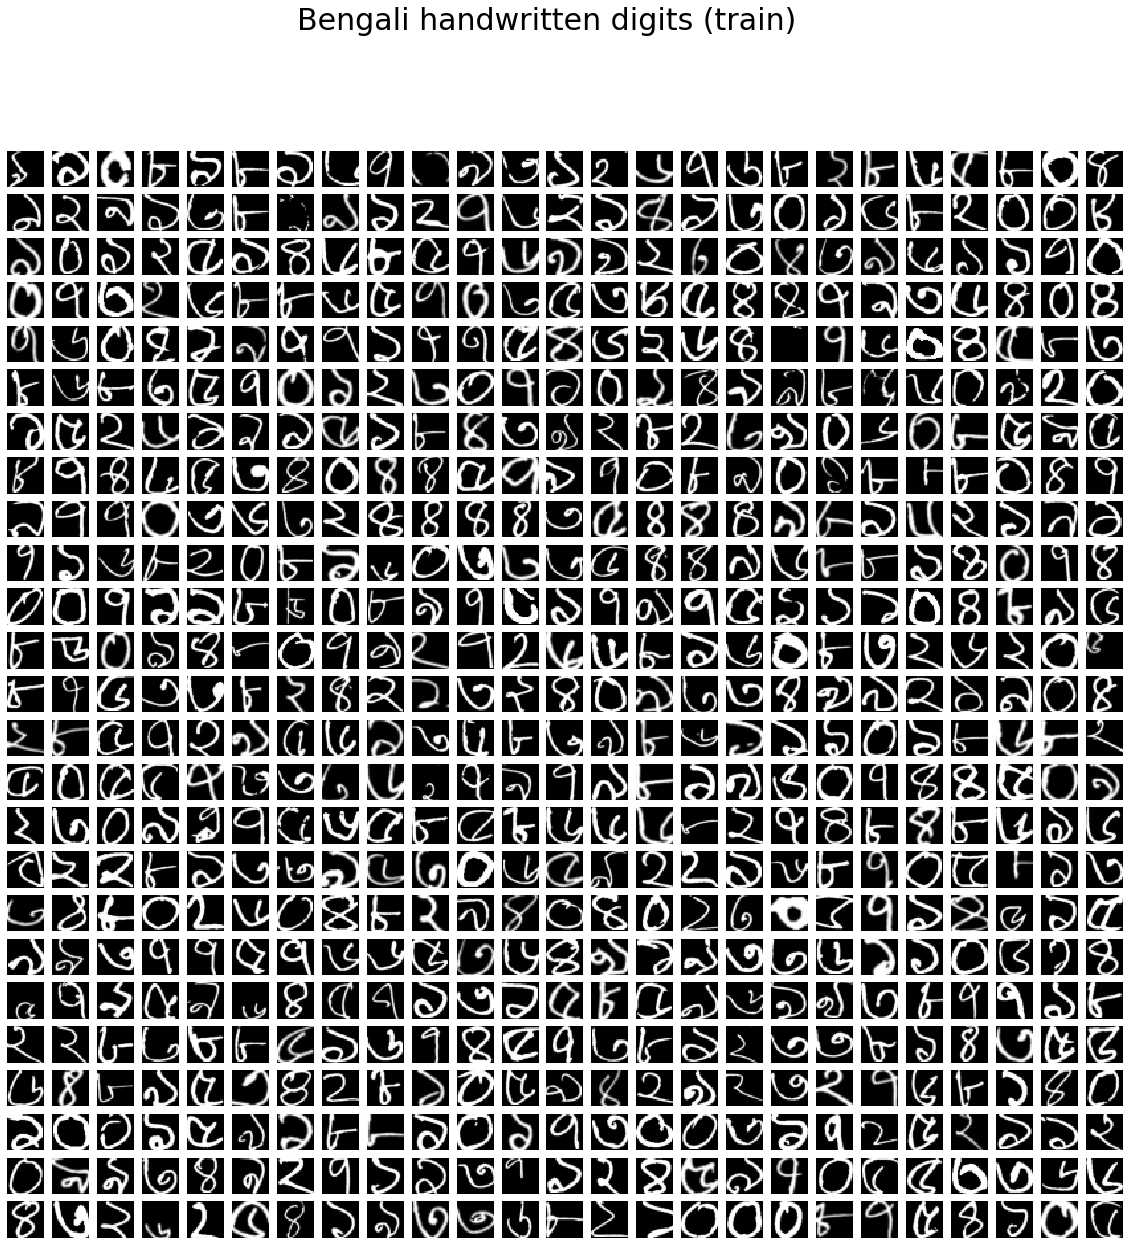

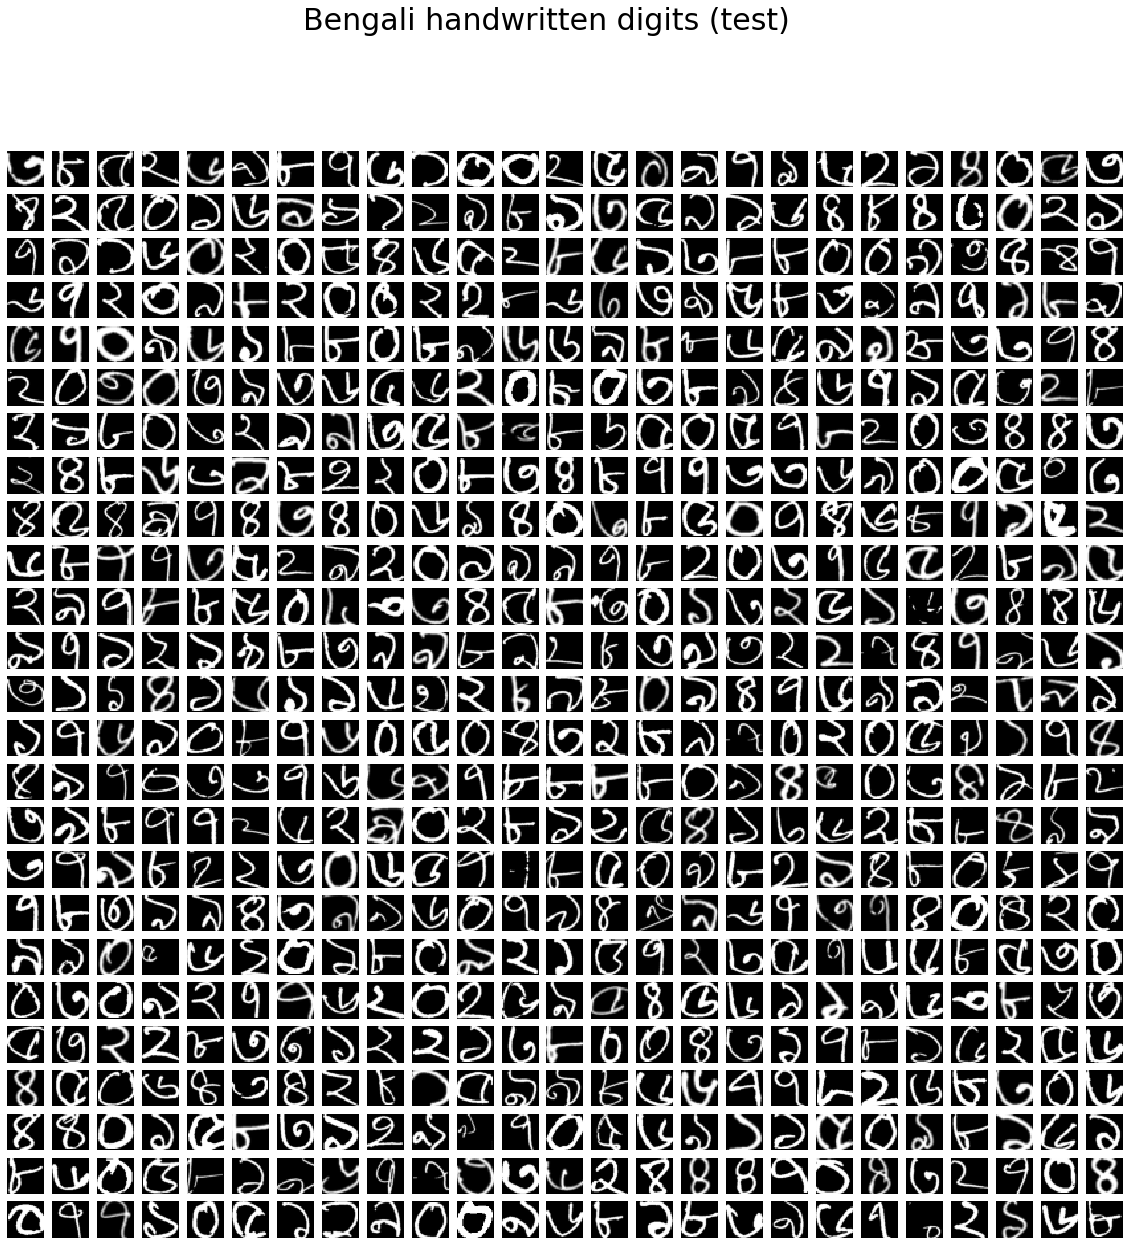

In [8]:
indices = np.random.choice(range(X_train.shape[0]), 625)
plt.figure(figsize=(20,20))
plt.gray()
for i in range(625):
    img = np.reshape(X_train[indices[i],:], (n,n))
    plt.subplot(25,25,i+1)
    plt.imshow(255*img)
    plt.axis('off')
plt.suptitle('Bengali handwritten digits (train)', size=30)
plt.savefig('digits_viz_train.png')
#plt.show()
plt.figure(figsize=(20,20))
plt.gray()
indices = np.random.choice(range(X_test.shape[0]), 625)
for i in range(625):
    img = np.reshape(X_test[indices[i],:], (n,n))
    plt.subplot(25,25,i+1)
    plt.imshow(255*img)
    plt.axis('off')
plt.suptitle('Bengali handwritten digits (test)', size=30)
plt.savefig('digits_viz_test.png')
plt.show()

### Varitaional AutoEncoder for Image Generation

In [4]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n*n, 512)
        self.fc21 = nn.Linear(512, 32) # mu
        self.fc22 = nn.Linear(512, 32) # sigma
        self.fc3 = nn.Linear(32, 512)
        self.fc4 = nn.Linear(512, n*n)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, n*n))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
torch.manual_seed(11)

cuda = torch.cuda.is_available()
batch_size = 128
log_interval = 20
epochs = 20
n = 28

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = DataLoader(np.reshape(X_train, (-1, 1, n, n)).astype(np.float32), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(np.reshape(X_test, (-1, 1, n, n)).astype(np.float32), batch_size=batch_size, shuffle=True)

#train_loader = torch.utils.data.DataLoader(
#    datasets.MNIST('../data', train=True, download=True,
#                   transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True, **kwargs)
#test_loader = torch.utils.data.DataLoader(
#    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True, **kwargs)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5) # 1e-4


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, n*n), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    batch_idx = 0
    train_loss = 0
    losses = []
    for data in train_loader:
    #for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        #print(recon_batch.shape, mu.shape, logvar.shape)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        losses.append(cur_loss / batch_size)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
        batch_idx += 1

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return losses

def test(epoch):
    model.eval()
    test_loss = 0
    losses = []
    i = 0
    with torch.no_grad():
        for data in test_loader:
        #for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            cur_loss = loss_function(recon_batch, data, mu, logvar).item()
            test_loss += cur_loss
            losses.append(cur_loss / batch_size)
            if i == 0:
                N = min(data.size(0), 8)
                comparison = torch.cat([data[:N],
                                      recon_batch.view(batch_size, 1, n, n)[:N]])
                save_image(comparison.cpu(),
                         'vae/reconstruction_' + str(epoch) + '.png', nrow=N)
                i += 1

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return losses

plt.figure(figsize=(10,40))    
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
j = 1
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)[:-1]
    test_loss = test(epoch)[:-1]
    if epoch % 5 == 0:
        plt.subplot(10, 2, j), plt.plot(range(len(train_loss)), train_loss, 'r.-'), plt.xlabel('batch'), plt.ylabel('loss'), plt.title('train')
        plt.subplot(10, 2, j+1), plt.plot(range(len(test_loss)), test_loss, 'r.-'), plt.xlabel('batch'), plt.ylabel('loss'), plt.title('test')
        j += 2
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, n, n),
                   'vae/sample_' + str(epoch) + '.png')
plt.savefig('images/loss.png')
plt.close()
#plt.show()
torch.save(model, 'models/vae.pth')

Train Epoch: 1 [0/16778 (0%)]	Loss: 546.893616
Train Epoch: 1 [2560/16778 (15%)]	Loss: 389.867950
Train Epoch: 1 [5120/16778 (30%)]	Loss: 367.941315
Train Epoch: 1 [7680/16778 (45%)]	Loss: 346.581848
Train Epoch: 1 [10240/16778 (61%)]	Loss: 336.989014
Train Epoch: 1 [12800/16778 (76%)]	Loss: 325.654388
Train Epoch: 1 [15360/16778 (91%)]	Loss: 309.071442
====> Epoch: 1 Average loss: 357.1471
====> Test set loss: 306.2300
Train Epoch: 2 [0/16778 (0%)]	Loss: 304.605774
Train Epoch: 2 [2560/16778 (15%)]	Loss: 296.487549
Train Epoch: 2 [5120/16778 (30%)]	Loss: 286.590546
Train Epoch: 2 [7680/16778 (45%)]	Loss: 279.364990
Train Epoch: 2 [10240/16778 (61%)]	Loss: 269.075165
Train Epoch: 2 [12800/16778 (76%)]	Loss: 250.586929
Train Epoch: 2 [15360/16778 (91%)]	Loss: 261.539185
====> Epoch: 2 Average loss: 278.0354
====> Test set loss: 257.1490
Train Epoch: 3 [0/16778 (0%)]	Loss: 259.940979
Train Epoch: 3 [2560/16778 (15%)]	Loss: 259.793884
Train Epoch: 3 [5120/16778 (30%)]	Loss: 242.993866
Tra

Train Epoch: 20 [5120/16778 (30%)]	Loss: 190.594910
Train Epoch: 20 [7680/16778 (45%)]	Loss: 194.316940
Train Epoch: 20 [10240/16778 (61%)]	Loss: 200.511505
Train Epoch: 20 [12800/16778 (76%)]	Loss: 199.130112
Train Epoch: 20 [15360/16778 (91%)]	Loss: 192.684937
====> Epoch: 20 Average loss: 192.3909
====> Test set loss: 197.0231


/usr/local/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Images decodes from the test images encodings with VAE

![](images/reconstructions.png)

### A Generated Image

![**Generated Image**](images/sample_36.png)

In [ ]:
#! pip3.7 install torchviz
import torch
from torchviz import make_dot
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
n = 28
model = torch.load('models/vae.pth')
x = torch.randn(1, 784).to(device)
out = model(x)
make_dot(out)

![](images/model.png)

In [5]:
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=32, bias=True)
  (fc22): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)
